In [ ]:
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import os
import numpy as np
import tensorflow_datasets as tfds
import warnings
warnings.filterwarnings('ignore')

In [ ]:
dataset, info = tfds.load(name='cassava', with_info=True, as_supervised=True, split=['train', 'test', 'validation'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5656 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cassava/0.1.0.incompleteMV0W2Y/cassava-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/1885 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cassava/0.1.0.incompleteMV0W2Y/cassava-test.tfrecord*...:   0%|          | 0/1…

Generating validation examples...:   0%|          | 0/1889 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cassava/0.1.0.incompleteMV0W2Y/cassava-validation.tfrecord*...:   0%|         …

Dataset cassava downloaded and prepared to ~/tensorflow_datasets/cassava/0.1.0. Subsequent calls will reuse this data.


The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


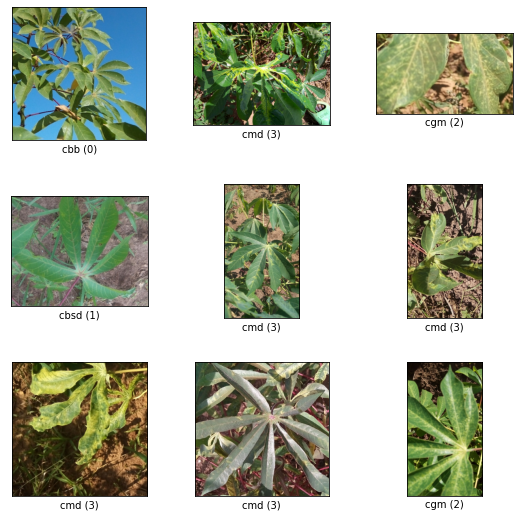

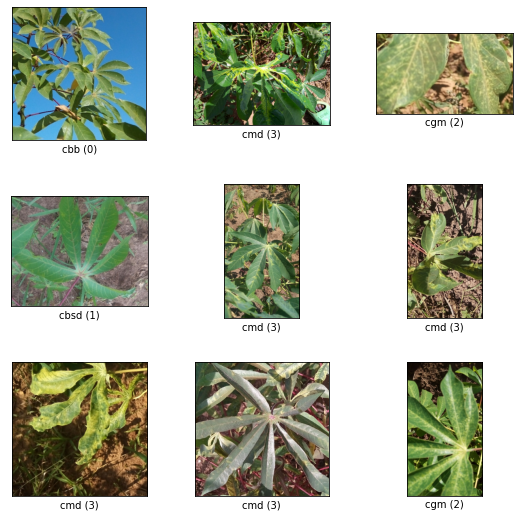

In [ ]:
train, info_train = tfds.load(name='cassava', with_info=True, split='test')
tfds.show_examples(info_train, train)

In [ ]:
def sc(image, label):
  image = tf.cast(image, tf.float32)
  image /=255.0
  return tf.image.resize(image,[224, 224]), tf.one_hot(label, 5)

In [ ]:
def get_dataset(batch_size = 32):
  train_dataset_sc = dataset[0].map(sc).shuffle(1000).batch(batch_size)
  test_dataset_sc = dataset[1].map(sc).batch(batch_size)
  val_dataset_sc = dataset[2].map(sc).batch(batch_size)
  return train_dataset_sc, test_dataset_sc, val_dataset_sc

In [ ]:
train_dataset, test_dataset, val_dataset = get_dataset()
train_dataset.cache()
val_dataset.cache()

<CacheDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [ ]:
f_e = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [ ]:
f_e_layer = hub.KerasLayer(f_e, input_shape=(224, 224, 3))

In [ ]:
f_e_layer.trainable = False

In [ ]:
model = tf.keras.Sequential([
    f_e_layer,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

In [ ]:
history = model.fit(train_dataset, epochs = 30, validation_data=val_dataset)

Epoch 1/30
177/177 [==============================] - 45s 177ms/step - loss: 1.0860 - acc: 0.5926 - val_loss: 0.7692 - val_acc: 0.7157
Epoch 2/30
177/177 [==============================] - 37s 193ms/step - loss: 0.8107 - acc: 0.6989 - val_loss: 0.7066 - val_acc: 0.7427
Epoch 3/30
177/177 [==============================] - 36s 176ms/step - loss: 0.7360 - acc: 0.7274 - val_loss: 0.6897 - val_acc: 0.7507
Epoch 4/30
177/177 [==============================] - 34s 173ms/step - loss: 0.7178 - acc: 0.7336 - val_loss: 0.7077 - val_acc: 0.7401
Epoch 5/30
177/177 [==============================] - 34s 173ms/step - loss: 0.6789 - acc: 0.7525 - val_loss: 0.7223 - val_acc: 0.7274
Epoch 6/30
177/177 [==============================] - 34s 173ms/step - loss: 0.6688 - acc: 0.7594 - val_loss: 0.6755 - val_acc: 0.7602
Epoch 7/30
177/177 [==============================] - 34s 173ms/step - loss: 0.6503 - acc: 0.7599 - val_loss: 0.6739 - val_acc: 0.7507
Epoch 8/30
177/177 [==============================] - 3

In [ ]:
res = model.evaluate(test_dataset)

59/59 [==============================] - 8s 128ms/step - loss: 0.6470 - acc: 0.7602


1/1 [==============================] - 0s 409ms/step


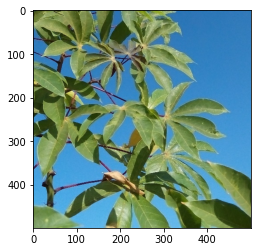

Given: cbb
Predicted: cmd
1/1 [==============================] - 0s 19ms/step


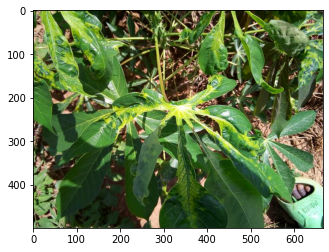

Given: cmd
Predicted: cmd
1/1 [==============================] - 0s 24ms/step


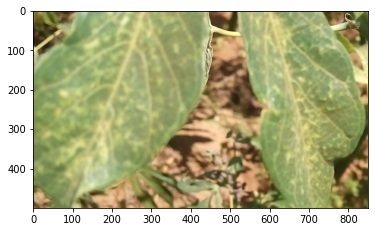

Given: cgm
Predicted: cbsd
1/1 [==============================] - 0s 22ms/step


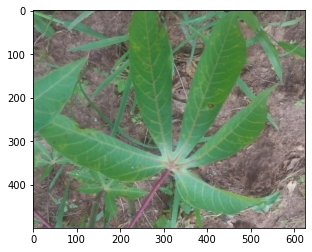

Given: cbsd
Predicted: cbsd
1/1 [==============================] - 0s 22ms/step


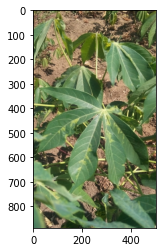

Given: cmd
Predicted: cmd
1/1 [==============================] - 0s 18ms/step


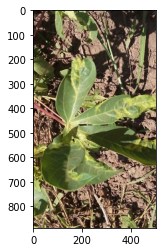

Given: cmd
Predicted: cmd
1/1 [==============================] - 0s 18ms/step


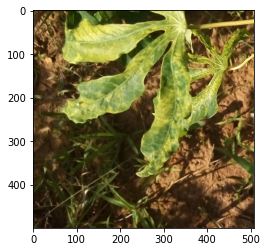

Given: cmd
Predicted: cmd
1/1 [==============================] - 0s 23ms/step


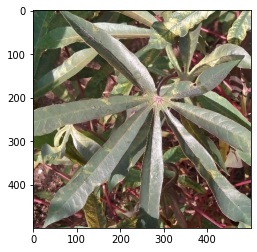

Given: cmd
Predicted: cgm
1/1 [==============================] - 0s 20ms/step


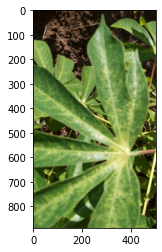

Given: cgm
Predicted: cgm
1/1 [==============================] - 0s 19ms/step


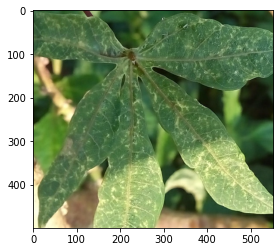

Given: cgm
Predicted: cmd


In [ ]:
for t_sample in dataset[1].take(10):
  image, label = t_sample[0], t_sample[1]
  img_sc, label_array = sc(t_sample[0], t_sample[1])
  img_sc = np.expand_dims(img_sc, axis = 0)
  img = tf.keras.preprocessing.image.img_to_array(image)
  pred = model.predict(img_sc)
  #print(pred)
  plt.figure()
  plt.imshow(image)
  plt.show()
  print("Given: %s" % info.features["label"].names[label.numpy()])
  print("Predicted: %s" % info.features["label"].names[np.argmax(pred)])

In [ ]:
for f0, f1 in dataset[1].map(sc).batch(200):
  y = np.argmax(f1, axis=1)
  y_pred = np.argmax(model.predict(f0), axis=1)
  print(tf.math.confusion_matrix(labels=y, predictions=y_pred, num_classes = 5))

7/7 [==============================] - 0s 50ms/step
tf.Tensor(
[[ 6  6  1  1  0]
 [ 2 37  1  8  0]
 [ 2  3 15  5  0]
 [ 0  9  3 85  0]
 [ 0  5  0  4  7]], shape=(5, 5), dtype=int32)
7/7 [==============================] - 0s 43ms/step
tf.Tensor(
[[ 4  9  2  2  1]
 [ 0 36  3 12  0]
 [ 0  0 15 10  0]
 [ 0  2  4 86  1]
 [ 0  3  0  2  8]], shape=(5, 5), dtype=int32)
7/7 [==============================] - 0s 41ms/step
tf.Tensor(
[[ 7  6  1  3  1]
 [ 2 46  1 10  1]
 [ 1  3 21  8  0]
 [ 0  2  2 75  0]
 [ 0  5  0  1  4]], shape=(5, 5), dtype=int32)
7/7 [==============================] - 0s 42ms/step
tf.Tensor(
[[ 2  2  1  3  0]
 [ 4 39  1  9  0]
 [ 0  4 16 10  2]
 [ 0  2  2 88  1]
 [ 0  6  0  1  7]], shape=(5, 5), dtype=int32)
7/7 [==============================] - 0s 45ms/step
tf.Tensor(
[[ 9  5  1  1  0]
 [ 2 38  3  7  0]
 [ 3  1 12  7  0]
 [ 0  3  3 96  0]
 [ 0  1  0  1  7]], shape=(5, 5), dtype=int32)
7/7 [==============================] - 0s 43ms/step
tf.Tensor(
[[ 6  6  2  1  0]
 [ 2 43  